In [35]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

In [36]:
def image(a1, a2):
    fig, ax = plt.subplots()
    ax.plot(a1, a2, '.')
    ax.grid()
    plt.show()

### Реализация решения задачи Коши
Регаем задачу Коши 2-го порядка, имеющую вид
$$
y'' = f(x, y, y')\\
y(L_1) = A,\;\;\; y'(L_2) = B
$$
Расщепляем на 2 задачи Коши 1-го порядка (заменой $z = y'$):
$$
z' = f(x, y, z),\;\;\;z(L_2) = B\\
y' = z, \;\;\;y(L_1) = A
$$
Решаем их совместно по схеме Эйлера.

In [52]:
class Cauchy_problem:
    def __init__(self, alpha, beta, L1, L2, f):
        self.alpha, self.L1, self.L2, self.f = alpha, L1, L2, f
        self.beta = beta
        
    def z_(self, x, y, z):
        return self.f.subs({symbols('x'): x, symbols('y'): y, symbols('z'): z})

    def y_iteration(self, y, z, h):
        return y + h * z

    def z_iteration(self, x, y, z, h):
        return z + h * self.z_(x, y, z)

    def solve_ZK_(self):
        N = 100
        h = (self.L2 - self.L1) / N
        arr_x, arr_y = [], []

        x0, y0, z0 = self.L1, self.beta, self.alpha
        x, y, z = x0, y0, z0
        arr_x.append(x0)
        arr_y.append(y0)

        for i in range(N):
            y_new = self.y_iteration(y, z, h)
            z_new = self.z_iteration(x, y, z, h)
            x_new = x + h
            x, y, z = x_new, y_new, z_new
            arr_x.append(x)
            arr_y.append(y)
        self.x, self.y = arr_x, arr_y
        
    def print_solution(self):
        print('Решение на отрезке [0, ' + str(L2) + ']:')
        for i in range(len(self.x)):
            print('y(' + str(round(self.x[i], 2)) + ') = ', round(self.y[i], 5))
        
    def solve(self):
        self.solve_ZK()
        self.print_solution()
        image(self.x, self.y)

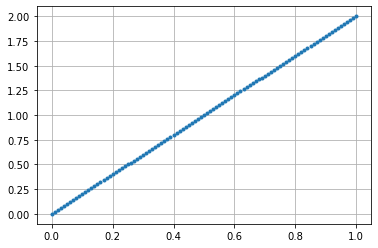

In [66]:
def f(t, u):
    alpha = 2
    a1 = dy_dt(u[0], u[1], alpha)
    a2 = dz_dt(u[0], u[1])
    return np.array([a1, a2])

alpha = 1
def RK4(t, u, h): 
    k1 = h * f(t, u)
    k2 = h * f(t + (1/2)*h, u + (1/2)*k1)
    k3 = h * f(t + (1/2)*h, u + (1/2)*k2)
    k4 = h * f(t + h, u + k3)
    return u + (k1/6) + (k2/3) + (k3/3) + (k4/6)

def solve_(alpha):
    u = np.array([0, alpha])
    u_ = [u]

    t = 0
    h = 1e-3
    T = 1
    while t < T:
        u = RK4(t, u, h)
        u_.append(u)
        t += h
    arr_x = np.linspace(0, T, num = int(T/h) + 1)

    u_ = np.array(u_)
    arr_y, arr_z = [], []
    for i in range(len(u_)):
        arr_y.append(u_[i][0])
        arr_z.append(u_[i][1])
    return arr_y[len(arr_y) - 1], [arr_x, arr_y]

a, c = solve_(1)
image(c[0], c[1])

In [ ]:
M = 5
eps = 10 ** (-M)
alpha_0 = np.pi
alpha = alpha_0

def y(x, alpha):
    a, c = solve_ZK(alpha)
    return a

def F(alpha):
    return y(1, alpha) - np.pi**2

def der_F(al):
    h = 1e-3
    return (F(al + h) - F(al)) / h

def alpha_(al):
    return al - F(al) / der_F(al)

b = True
i = 0
while b:
    i += 1
    if abs(F(alpha)) > eps:
        alpha = alpha_(alpha)
    else:
        b = False
        a, c = solve_ZK(alpha)

arr_x, arr_y = c[0], c[1]

plot(arr_x, arr_y)

print('Количество итераций поиска альфы =', i)
for i in range(len(arr_x)):
    print('y(' + str(round(arr_x[i], 2)) + ') = ', round(arr_y[i], M))

### Реализация метода пристрелки
Решаем задачу  Коши вида:
$$
y'' = f(x, y, y'),\\
y(L_1) = A,\;\;\;y'(L_2) = \alpha
$$
Подбираем $\alpha$ до тех пор, пока с нужной точностью не удовлетворится условие:
$$
\left|{y(L_2, \alpha) - B}\right| < \varepsilon
$$

In [59]:
class shooting_procedure:
    def __init__(self, f, L1, L2, A, B):
        self.M = 5
        self.L1, self.L2 = L1, L2
        self.f = f
        self.A, self.B = A, B
        return
    
    def y(self, alpha):
        S = Cauchy_problem(alpha, self.A, self.L1, self.L2, self.f)
        S.solve_ZK_()
        return S.y[len(S.y) - 1]

    def F(self, alpha):
        return self.y(alpha) - self.B

    def der_F(self, al):
        h = 1e-3
        return (self.F(al + h) - self.F(al)) / h

    def alpha_(self, al):
        return al - self.F(al) / self.der_F(al)
    
    def print_solution(self):
        print('Количество итераций поиска альфы =', self.i)
        for i in range(len(self.x)):
            print('y(' + str(round(self.x[i], 2)) + ') = ', round(self.y[i], self.M))
    
    def shooting(self):
        eps = 10 ** (-self.M)
        alpha = (self.B - self.A) / (self.L2 - self.L1)
        i = 0
        while 1:
            i += 1
            if abs(self.F(alpha)) > eps:
                alpha = self.alpha_(alpha)
            else:
                b = False
                S = Cauchy_problem(alpha, self.A, self.L1, self.L2, self.f)
                S.solve_ZK_()
                self.x, self.y = S.x, S.y
                self.i = i
                self.alpha = alpha
                return
    
    def shoot(self):
        self.shooting()
        self.print_solution()
        image(self.x, self.y)

Количество итераций поиска альфы = 3
y(0) =  0
y(0.01) =  0.01848
y(0.02) =  0.03697
y(0.03) =  0.05545
y(0.04) =  0.07393
y(0.05) =  0.09242
y(0.06) =  0.11090
y(0.07) =  0.12939
y(0.08) =  0.14788
y(0.09) =  0.16637
y(0.1) =  0.18487
y(0.11) =  0.20336
y(0.12) =  0.22187
y(0.13) =  0.24037
y(0.14) =  0.25889
y(0.15) =  0.27741
y(0.16) =  0.29593
y(0.17) =  0.31447
y(0.18) =  0.33301
y(0.19) =  0.35156
y(0.2) =  0.37013
y(0.21) =  0.38870
y(0.22) =  0.40729
y(0.23) =  0.42589
y(0.24) =  0.44450
y(0.25) =  0.46313
y(0.26) =  0.48177
y(0.27) =  0.50044
y(0.28) =  0.51912
y(0.29) =  0.53782
y(0.3) =  0.55653
y(0.31) =  0.57527
y(0.32) =  0.59404
y(0.33) =  0.61282
y(0.34) =  0.63163
y(0.35) =  0.65047
y(0.36) =  0.66934
y(0.37) =  0.68823
y(0.38) =  0.70715
y(0.39) =  0.72610
y(0.4) =  0.74508
y(0.41) =  0.76410
y(0.42) =  0.78315
y(0.43) =  0.80224
y(0.44) =  0.82137
y(0.45) =  0.84053
y(0.46) =  0.85973
y(0.47) =  0.87898
y(0.48) =  0.89826
y(0.49) =  0.91760
y(0.5) =  0.93697
y(0.51) 

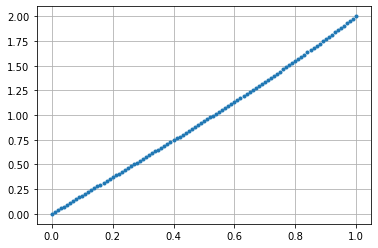

1.84831495088238


In [64]:
# Задание функции z = f(x, y, z)
x, y, z = symbols('x y z')
f = x * sqrt(y)

# Задание параметров задачи
A, B = 0, 2
L1, L2 = 0, 1

P = shooting_procedure(f, L1, L2, A, B)
P.shoot()
d_ = [P.x, P.y]
print(P.alpha)

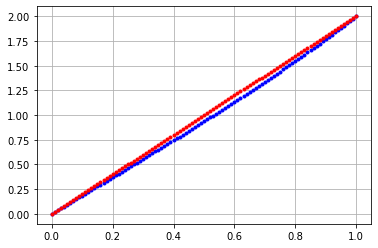

In [63]:
fig, ax = plt.subplots()
ax.plot(P.x, P.y, '.', color = 'blue')
ax.plot(c_[0], c_[1], '.', color = 'red')
ax.grid()
plt.show()